### In this notebook we used a pre trained yolo on speed sings detection, and fine tune it on arabic signs.

In [ ]:
# import os

# # Path to merged dataset
# merged_dir = '/kaggle/input/almost-clean-ss'

# # Collect all unique classes
# unique_classes = set()

# # Loop over all subsets
# for subset in ['train', 'valid', 'test']:
#     label_dir = os.path.join(merged_dir, subset, 'labels')
#     if not os.path.exists(label_dir):
#         continue
#     for file in os.listdir(label_dir):
#         if file.endswith('.txt'):
#             with open(os.path.join(label_dir, file), 'r') as f:
#                 for line in f:
#                     if line.strip():
#                         class_id = int(line.strip().split()[0])
#                         unique_classes.add(class_id)

# # Sort and display
# unique_classes = sorted(list(unique_classes))
# print(f"✅ Found {len(unique_classes)} unique class IDs:")
# print(unique_classes)
names: ['speed_030', 'speed_030_aen', 'speed_040', 'speed_040_aen', 'speed_040_ar', 'speed_050', 'speed_050_ar', 'speed_060', 'speed_060_aen', 'speed_060_ar', 'speed_070', 'speed_070_aen', 'speed_070_ar', 'speed_080', 'speed_080_aen', 'speed_080_ar', 'speed_090', 'speed_090_ar', 'speed_100', 'speed_100_aen', 'speed_100_ar', 'speed_110', 'speed_110_ar', 'speed_120', 'speed_120_ar', 'speed_130', 'speed_140_aen']



##  Install And Import Essential Libreries</b> 


In [2]:
!pip install --upgrade ultralytics ray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 18.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.5.1
    Uninstalling ray-2.5.1:
      Successfully uninstalled ray-2.5.1


In [ ]:
# # Install Essential Libraries
# !pip install ultralytics

In [3]:
# Import Essential Libraries
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

##  Dataset
 Show Original Images Before Detect 


Show Some Images From TrainSet

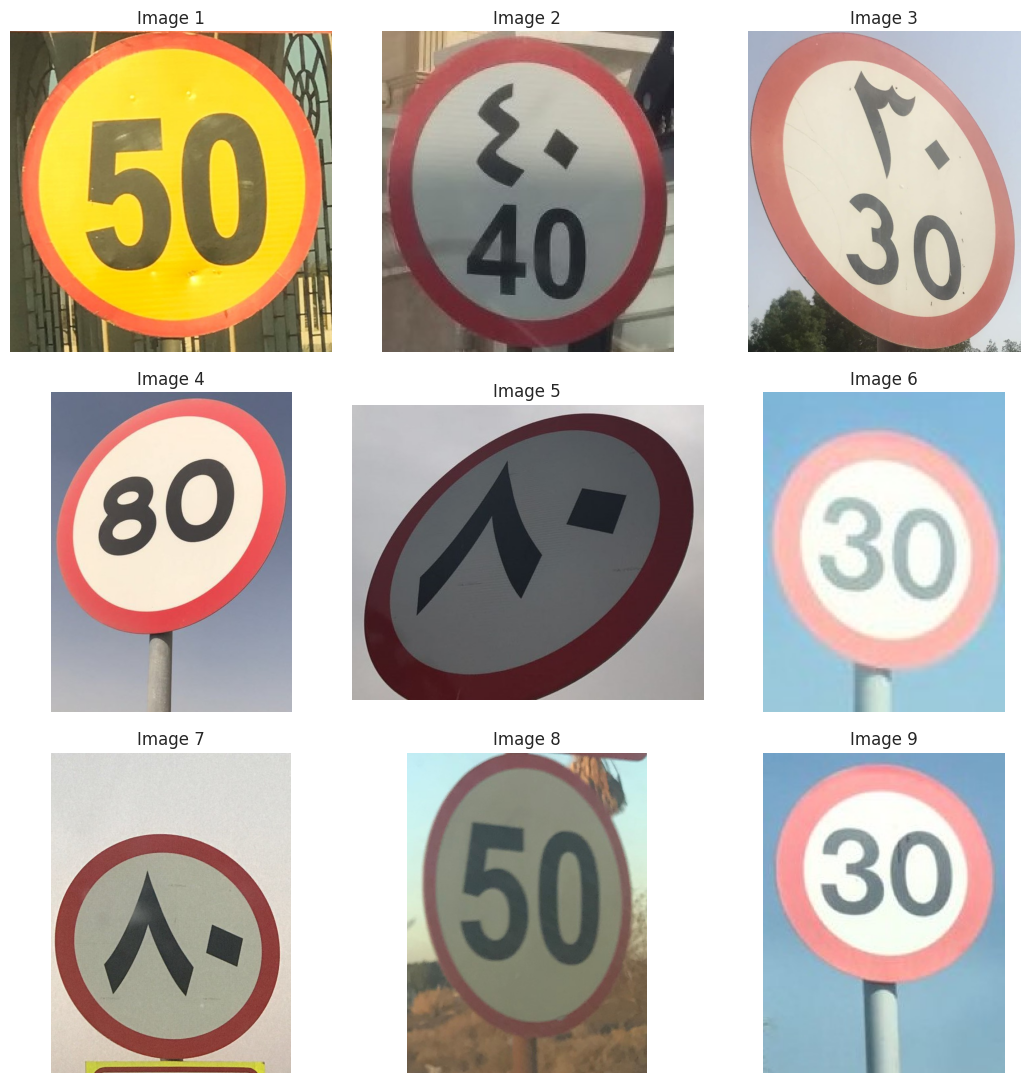

In [5]:
Image_dir = '/kaggle/input/ss-imgs/rawdata'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Get Shape Of An Image For Using In Training Step

In [6]:
# Get the size of the image
image = cv2.imread("/kaggle/input/ss-imgs/rawdata/speed_100-38977.JPG")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 1487x1543 and 3 channels.


# data labeling and preprocessing
### arabic signs labels were not labeled, so we used the model to label them and find their bbox.

In [16]:
# arabic_images_dir = "/kaggle/input/ss-imgs/rawdata/"
# results = Final_model.predict(source=arabic_images_dir, save_txt=True, imgsz=640)


image 1/1 /kaggle/input/ss-imgs/rawdata/speed_100-38977.JPG: 640x640 1 Speed Limit 40, 1 Speed Limit 70, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


In [9]:
import os

# Paths
image_dir = "/kaggle/input/ss-imgs/rawdata"
label_dir = "/kaggle/working/runs/detect/predict/labels"

# List all images and expected label files
images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.JPG'))]
missing_labels = []

for img in images:
    txt_file = os.path.join(label_dir, os.path.splitext(img)[0] + '.txt')
    if not os.path.exists(txt_file):
        missing_labels.append(img)
        # Create empty file if no detections
        # open(txt_file, 'a').close()  # Creates empty .txt file

print(f"Missing labels: {missing_labels}")

Missing labels: ['speed_100-39376.JPG', 'speed_60-48091.JPG', 'speed_40-45487.JPG', 'speed_60-48742.JPG', 'speed_50-46180.JPG', 'speed_60-48637.JPG', 'speed_100-39418.JPG', 'speed_60-48112.JPG', 'speed_40-45004.JPG', 'speed_50-46075.JPG', 'speed_40-44248.JPG', 'speed_60-49120.JPG', 'speed_60-48868.JPG', 'speed_100-39859.JPG', 'speed_100-39481.JPG', 'speed_30-43009.JPG', 'speed_40-45550.JPG', 'speed_50-45802.JPG', 'speed_60-48700.JPG', 'speed_40-45298.JPG', 'speed_60-48070.JPG', 'speed_80-52354.JPG', 'speed_80-50695.JPG', 'speed_60-48763.JPG', 'speed_50-45865.JPG', 'speed_40-45025.JPG', 'speed_30-41497.JPG', 'speed_60-49372.JPG', 'speed_80-51703.JPG', 'speed_80-50758.JPG', 'speed_40-45466.JPG', 'speed_100-39439.JPG', 'speed_40-44962.JPG', 'speed_50-47881.JPG', 'speed_40-45172.JPG', 'speed_80-50674.JPG']


In [13]:
import os
import shutil

# Define paths
image_source = "/kaggle/input/ss-imgs/rawdata"  # Original images
label_source = "/kaggle/working/runs/detect/predict/labels"  # Predicted labels
output_dir = "/kaggle/working/temp_data"  # Output folder

# Create output directories
os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "labels"), exist_ok=True)

# Get list of all images and filter out missing_labels
all_images = [f for f in os.listdir(image_source) if f.endswith(('.jpg', '.JPG', '.png'))]
# missing_labels = ['speed_100-39019.JPG', 'speed_100-39500.JPG']  # Add your missing files here
valid_images = [img for img in all_images if img not in missing_labels]

# Copy images and their corresponding labels
for img in valid_images:
    # Copy image
    img_src = os.path.join(image_source, img)
    img_dst = os.path.join(output_dir, "images", img)
    shutil.copy2(img_src, img_dst)
    
    # Copy label (if exists)
    label_name = os.path.splitext(img)[0] + '.txt'
    label_src = os.path.join(label_source, label_name)
    label_dst = os.path.join(output_dir, "labels", label_name)
    
    if os.path.exists(label_src):
        shutil.copy2(label_src, label_dst)
    else:
        # Create empty label file if missing (optional)
        open(label_dst, 'a').close()

print(f"Created combined dataset in {output_dir}")
print(f"Excluded {len(missing_labels)} images: {missing_labels}")

Created combined dataset in /kaggle/working/temp_data
Excluded 36 images: ['speed_100-39376.JPG', 'speed_60-48091.JPG', 'speed_40-45487.JPG', 'speed_60-48742.JPG', 'speed_50-46180.JPG', 'speed_60-48637.JPG', 'speed_100-39418.JPG', 'speed_60-48112.JPG', 'speed_40-45004.JPG', 'speed_50-46075.JPG', 'speed_40-44248.JPG', 'speed_60-49120.JPG', 'speed_60-48868.JPG', 'speed_100-39859.JPG', 'speed_100-39481.JPG', 'speed_30-43009.JPG', 'speed_40-45550.JPG', 'speed_50-45802.JPG', 'speed_60-48700.JPG', 'speed_40-45298.JPG', 'speed_60-48070.JPG', 'speed_80-52354.JPG', 'speed_80-50695.JPG', 'speed_60-48763.JPG', 'speed_50-45865.JPG', 'speed_40-45025.JPG', 'speed_30-41497.JPG', 'speed_60-49372.JPG', 'speed_80-51703.JPG', 'speed_80-50758.JPG', 'speed_40-45466.JPG', 'speed_100-39439.JPG', 'speed_40-44962.JPG', 'speed_50-47881.JPG', 'speed_40-45172.JPG', 'speed_80-50674.JPG']


In [16]:
import os
import re

# Paths
label_dir = "/kaggle/working/temp_data/labels"  # Directory with .txt label files
image_dir = "/kaggle/working/temp_data/images"  # Directory with images (for filename reference)

# Your class names from data.yaml (indexes 0-14)
class_names = [
    'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100',
    'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30',
    'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70',
    'Speed Limit 80', 'Speed Limit 90', 'Stop'
]

# Create mapping: speed value → class index
speed_to_class = {}
for idx, name in enumerate(class_names):
    if "Speed Limit" in name:
        speed = int(name.split()[-1])  # Extract numeric value (e.g., 100)
        speed_to_class[speed] = idx

# Process all label files
for label_file in os.listdir(label_dir):
    if not label_file.endswith(".txt"):
        continue
    
    # Get corresponding image name
    image_name = label_file.replace(".txt", ".JPG")
    image_path = os.path.join(image_dir, image_name)
    
    # Extract speed value from image filename (e.g., "100" from "speed_100-38977.JPG")
    match = re.search(r"speed_(\d+)", image_name)
    if not match:
        print(f"Skipping {image_name}: no speed value in filename")
        continue
    
    speed = int(match.group(1))
    if speed not in speed_to_class:
        print(f"Skipping {image_name}: no class for Speed Limit {speed}")
        continue
    
    # Get correct class index
    correct_class = speed_to_class[speed]
    
    # Update the label file
    label_path = os.path.join(label_dir, label_file)
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        # Replace old class index with corrected one
        parts[0] = str(correct_class)
        new_lines.append(" ".join(parts))
    
    # Write corrected labels
    with open(label_path, "w") as f:
        f.write("\n".join(new_lines))

print("Class indices updated successfully!")

Class indices updated successfully!


In [19]:
import os

label_dir = "/kaggle/working/temp_data/labels"  # Path to your labels

for label_file in os.listdir(label_dir):
    label_path = os.path.join(label_dir, label_file)
    
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    # Keep only the first line (first object)
    if len(lines) > 1:
        with open(label_path, "w") as f:
            f.write(lines[0].strip())  # Overwrite with first line only
    
    # Ensure empty files stay empty (optional)
    elif len(lines) == 0:
        pass  # Do nothing (keep empty)

In [20]:
import shutil

# Paths
source_dir = "/kaggle/working/temp_data"
output_zip = "/kaggle/working/temp_data.zip"

# Create ZIP file
shutil.make_archive(
    base_name=output_zip.replace(".zip", ""),  # Remove extension
    format="zip",
    root_dir=source_dir
)

print(f"ZIP file created at: {output_zip}")

ZIP file created at: /kaggle/working/temp_data.zip


5.1.1. Training Step

In [6]:
# Build from YAML and transfer weights
Final_model = YOLO('/kaggle/input/signs_detc_best_ar/tensorflow2/default/1/best_ar.pt')  

# Training The Final Model
Result_Final_model_resume = Final_model.train(data="/kaggle/working/filtered_dataset/data.yaml",epochs = 10, batch = -1, optimizer = 'auto' )


Ultralytics 8.3.126 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/filtered_dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/signs_detc_best_ar/tensorflow2/default/1/best_ar.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

train: Scanning /kaggle/working/filtered_dataset/train/labels... 7523 images, 2 backgrounds, 0 corrupt: 100%|██████████| 7523/7523 [00:05<00:00, 1277.35it/s]


train: New cache created: /kaggle/working/filtered_dataset/train/labels.cache
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.37G reserved, 0.11G allocated, 14.27G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3013188       8.206         0.516         87.36         653.1        (1, 3, 640, 640)                    list
     3013188       16.41         0.684         20.59         207.3        (2, 3, 640, 640)                    list
     3013188       32.82         0.963            22         173.3        (4, 3, 640, 640)                    list
     3013188       65.65         1.468         26.94         162.2        (8, 3, 640, 640)                    list
     3013188       131.3         2.561         50.26         174.5       (16

train: Scanning /kaggle/working/filtered_dataset/train/labels.cache... 7523 images, 2 backgrounds, 0 corrupt: 100%|██████████| 7523/7523 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 390.9±251.9 MB/s, size: 26.3 KB)


val: Scanning /kaggle/working/filtered_dataset/valid/labels... 1377 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1377/1377 [00:01<00:00, 1121.95it/s]

val: New cache created: /kaggle/working/filtered_dataset/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004921875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.82G      1.113      3.626       1.43         28        640: 100%|██████████| 120/120 [01:21<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


                   all       1377       1474      0.883      0.472      0.507       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.82G     0.4663      1.526     0.9695         25        640: 100%|██████████| 120/120 [01:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


                   all       1377       1474      0.963      0.565      0.646      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.81G     0.4199     0.9464     0.9315         26        640: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]

                   all       1377       1474      0.945      0.632      0.704      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.81G     0.3971     0.6445     0.9138         30        640: 100%|██████████| 120/120 [01:17<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]

                   all       1377       1474      0.958      0.663      0.774      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.81G      0.375     0.4816     0.8974         26        640: 100%|██████████| 120/120 [01:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]

                   all       1377       1474      0.941       0.65      0.749      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.81G     0.3628      0.406     0.8912         27        640: 100%|██████████| 120/120 [01:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]

                   all       1377       1474       0.96      0.687      0.786      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.81G     0.3514     0.3585     0.8884         28        640: 100%|██████████| 120/120 [01:19<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]

                   all       1377       1474      0.968      0.687      0.779      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.81G      0.344     0.3267     0.8853         30        640: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]

                   all       1377       1474      0.759      0.792      0.884      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.81G     0.3365     0.3002     0.8792         28        640: 100%|██████████| 120/120 [01:19<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]

                   all       1377       1474      0.812      0.796      0.818      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.81G     0.3264     0.2811     0.8728         28        640: 100%|██████████| 120/120 [01:17<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]

                   all       1377       1474      0.927      0.787      0.886      0.824



10 epochs completed in 0.246 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


                   all       1377       1474      0.926      0.787      0.886      0.824
             speed_030          1          1          1          0      0.995      0.995
             speed_040        180        180       0.99          1      0.995      0.993
             speed_050        194        196      0.955       0.98      0.993      0.984
             speed_060        227        227      0.961      0.978      0.992      0.973
             speed_070         12         15      0.717          1       0.92      0.709
             speed_080        443        452      0.913      0.989      0.989      0.924
             speed_090        109        109      0.983      0.972      0.994      0.936
             speed_100        143        146      0.913      0.933      0.979      0.885
             speed_110          1          1          1          0     0.0199     0.0179
             speed_120        127        141      0.897      0.972      0.979      0.785
             speed_14


image 1/1 /kaggle/input/ss-imgs/rawdata/speed_100-39019.JPG: 640x640 1 speed_100, 6.1ms
Speed: 3.3ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


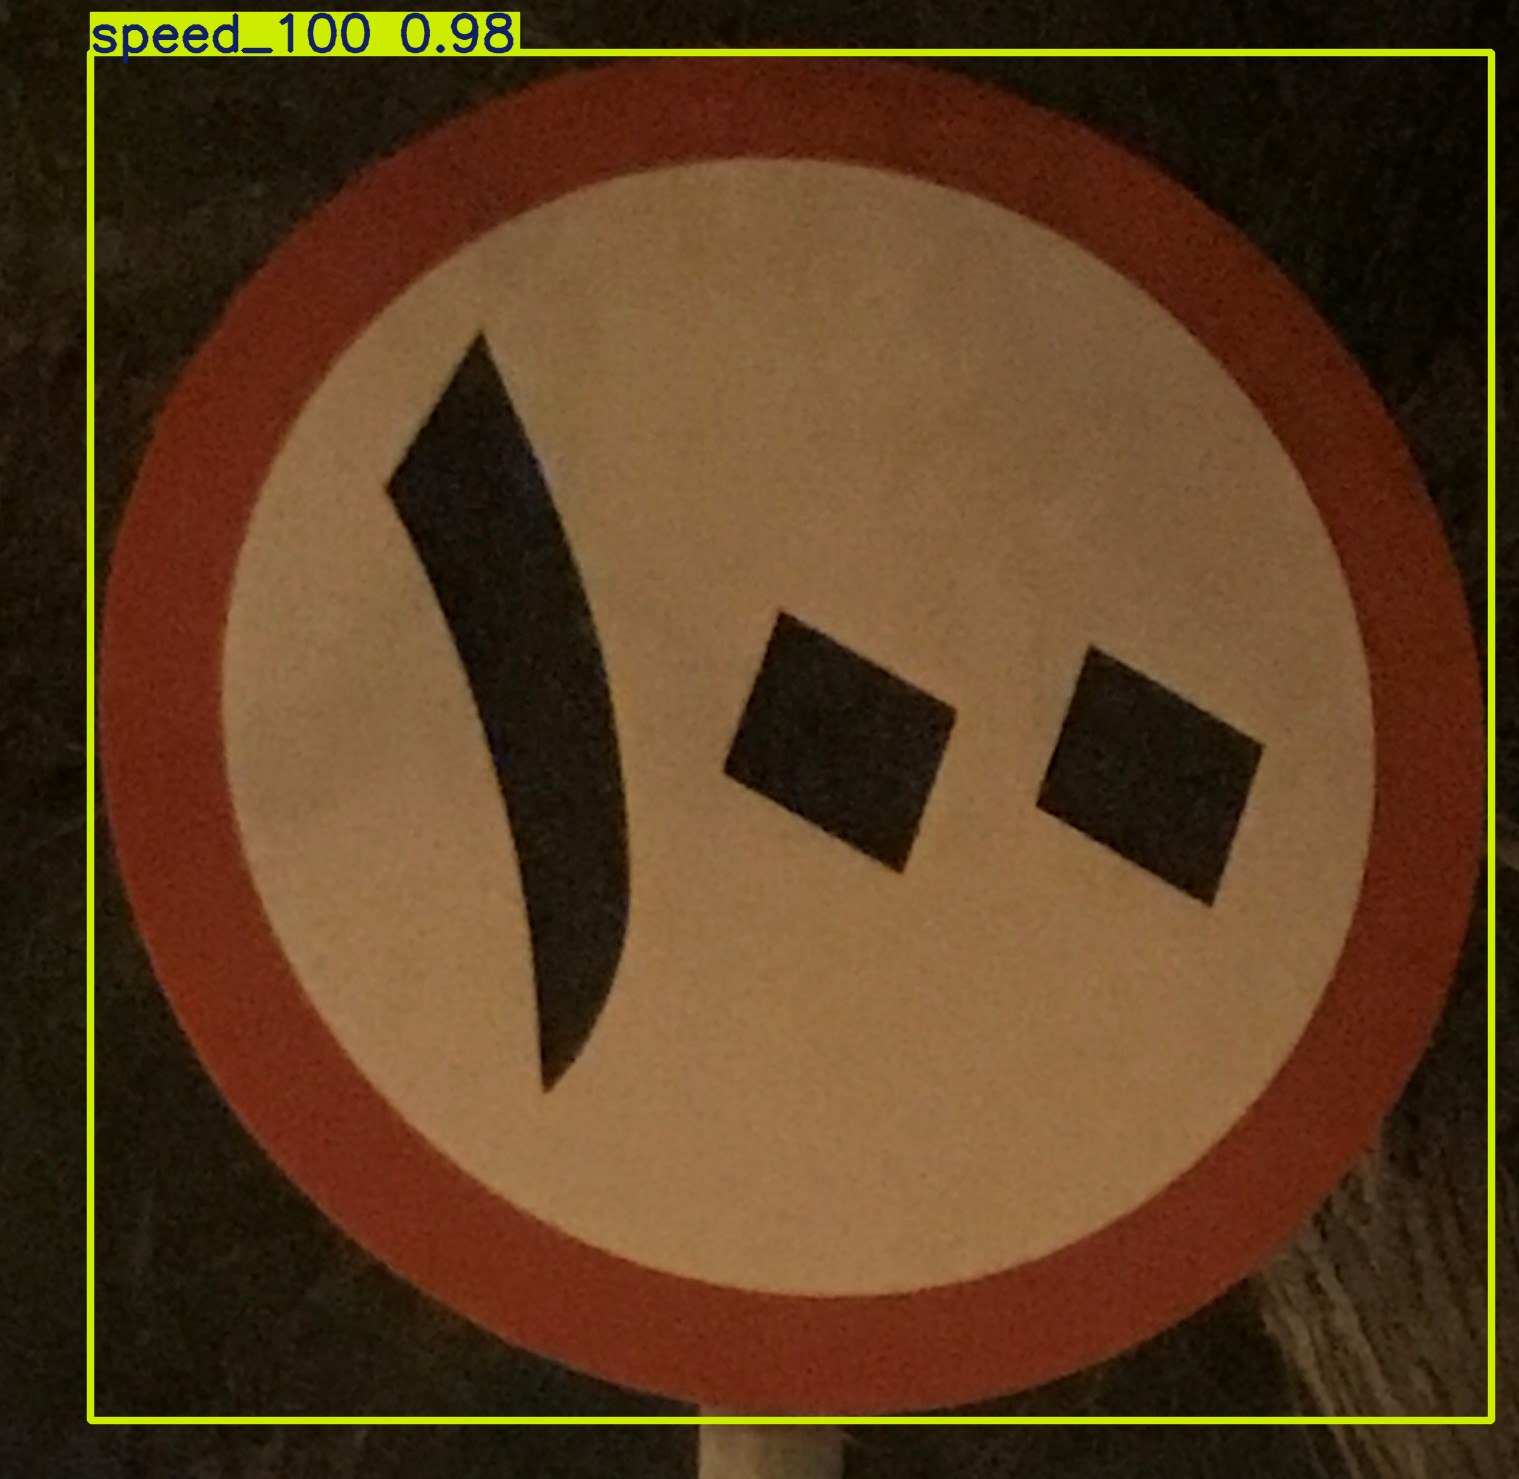

In [7]:


# Use the model to detect object
image = "/kaggle/input/ss-imgs/rawdata/speed_100-39019.JPG"
result_predict = Final_model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))


image 1/1 /kaggle/input/ss-imgs/rawdata/speed_100-38977.JPG: 640x640 1 speed_100, 6.3ms
Speed: 3.3ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


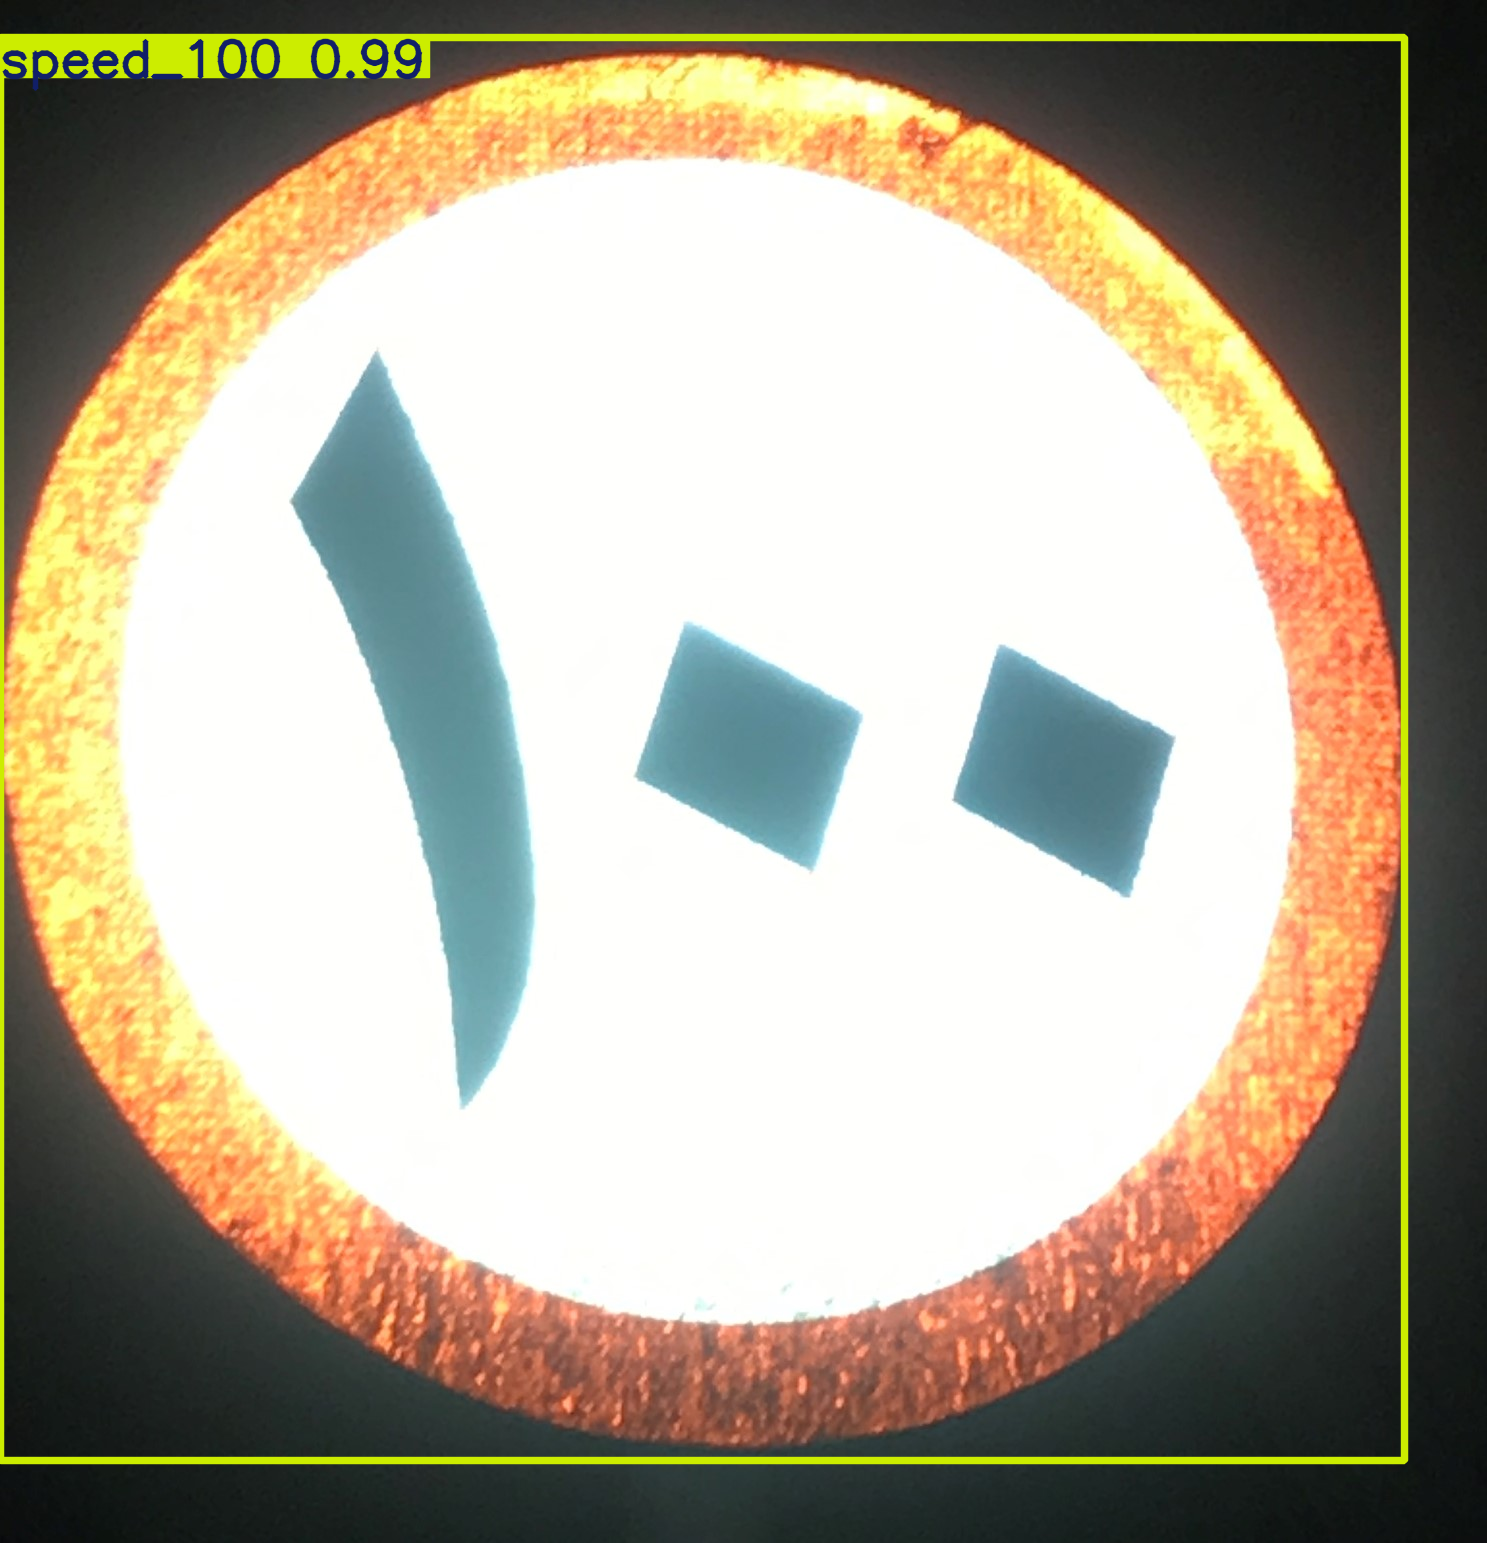

In [8]:
# # Use a pretrained YOLOv8n model
# model = YOLO("yolov8n.pt") 

# Use the model to detect object
image = "/kaggle/input/ss-imgs/rawdata/speed_100-38977.JPG"
result_predict = Final_model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))


image 1/1 /kaggle/input/ss-imgs/rawdata/speed_40-44563.JPG: 544x640 1 speed_040, 76.9ms
Speed: 2.5ms preprocess, 76.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


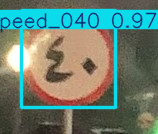

In [9]:
# # Use a pretrained YOLOv8n model
# model = YOLO("yolov8n.pt") 

# Use the model to detect object
image = "/kaggle/input/ss-imgs/rawdata/speed_40-44563.JPG"
result_predict = Final_model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))


image 1/1 /kaggle/input/ss-imgs/rawdata/speed_60-49288.JPG: 640x640 1 speed_060, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


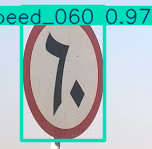

In [10]:
# # Use a pretrained YOLOv8n model
# model = YOLO("yolov8n.pt") 

# Use the model to detect object
image = "/kaggle/input/ss-imgs/rawdata/speed_60-49288.JPG"
result_predict = Final_model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

***5.1.2. Validation Step***

In [11]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/runs/detect/train'

# Display the images
display_images(post_training_files_path, image_files)


[ WARN:0@981.132] global loadsave.cpp:248 findDecoder imread_('/kaggle/working/runs/detect/train/confusion_matrix_normalized.png'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [25]:
Result_Final_model = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
Result_Final_model.tail(10)

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
20     21   871.388         0.52104         0.37009         0.92529   
21     22   909.956         0.52468         0.36946         0.92115   
22     23   949.312         0.50761         0.33787         0.92583   
23     24   988.694         0.50595         0.33957         0.91068   
24     25  1027.670         0.50756         0.32600         0.91480   
25     26  1066.050         0.48825         0.32101         0.90158   
26     27  1105.100         0.48839         0.31588         0.90006   
27     28  1143.540         0.47841         0.30082         0.90681   
28     29  1182.500         0.46731         0.29708         0.89204   
29     30  1220.190         0.46449         0.28872         0.88917   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
20               0.92839            0.89589           0.94791   
21               0.95206            0.90983           0.96493   
22               0.96221            0.90251           0.96329   
23               0.94329            0.90634           0.96332   
24               0.92773            0.92173           0.96181   
25               0.95827            0.91655           0.96425   
26               0.94735            0.91959           0.96499   
27               0.94072            0.92550           0.96614   
28               0.96513            0.90975           0.96808   
29               0.94852            0.92042           0.96576   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
20              0.81023       0.54323       0.36571       0.94599  0.000179   
21              0.83071       0.54192       0.33816       0.94022  0.000161   
22              0.82979       0.53900       0.35013       0.93747  0.000144   
23              0.82883       0.53569       0.33961       0.93761  0.000127   
24              0.82774       0.53271       0.33651       0.93611  0.000109   
25              0.83319       0.53688       0.32237       0.93857  0.000092   
26              0.83945       0.52379       0.31943       0.93227  0.000075   
27              0.83808       0.51773       0.31138       0.92710  0.000057   
28              0.83671       0.51769       0.30846       0.92807  0.000040   
29              0.83576       0.51356       0.30409       0.92643  0.000023   

      lr/pg1    lr/pg2  
20  0.000179  0.000179  
21  0.000161  0.000161  
22  0.000144  0.000144  
23  0.000127  0.000127  
24  0.000109  0.000109  
25  0.000092  0.000092  
26  0.000075  0.000075  
27  0.000057  0.000057  
28  0.000040  0.000040  
29  0.000023  0.000023

In [ ]:
# Read the results.csv file as a pandas dataframe
Result_Final_model.columns = Result_Final_model.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=Result_Final_model, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=Result_Final_model, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=Result_Final_model, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=Result_Final_model, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=Result_Final_model, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=Result_Final_model, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=Result_Final_model, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=Result_Final_model, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=Result_Final_model, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=Result_Final_model, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227''>5.2 |</span></b> Validation of the Model By TestSet </b></p>
</div>

In [26]:
# Loading the best performing model
Valid_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.122 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.5 ms, read: 21.8±10.8 MB/s, size: 11.2 KB)


val: Scanning /kaggle/input/cardetection/car/valid/labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:01<00:00, 749.35it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/cardetection/car/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  6.94it/s]


                   all        801        944      0.948       0.92      0.965       0.84
           Green Light         87        122      0.831      0.766      0.863      0.526
             Red Light         74        108      0.853      0.759      0.843      0.536
       Speed Limit 100         52         52      0.896      0.996      0.974      0.879
       Speed Limit 110         17         17          1      0.858      0.987      0.911
       Speed Limit 120         60         60      0.983      0.982      0.994      0.919
        Speed Limit 20         56         56      0.987      0.982      0.987      0.884
        Speed Limit 30         71         74      0.962      0.959      0.989      0.926
        Speed Limit 40         53         55      0.932      0.982      0.994      0.884
        Speed Limit 50         68         71      0.967      0.901      0.962      0.873
        Speed Limit 60         76         76       0.96      0.937       0.98      0.893
        Speed Limit 7


0: 640x640 1 speed_050, 1 speed_080, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 speed_120_ar, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 speed_090_ar, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 speed_040_aen, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 speed_080, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4

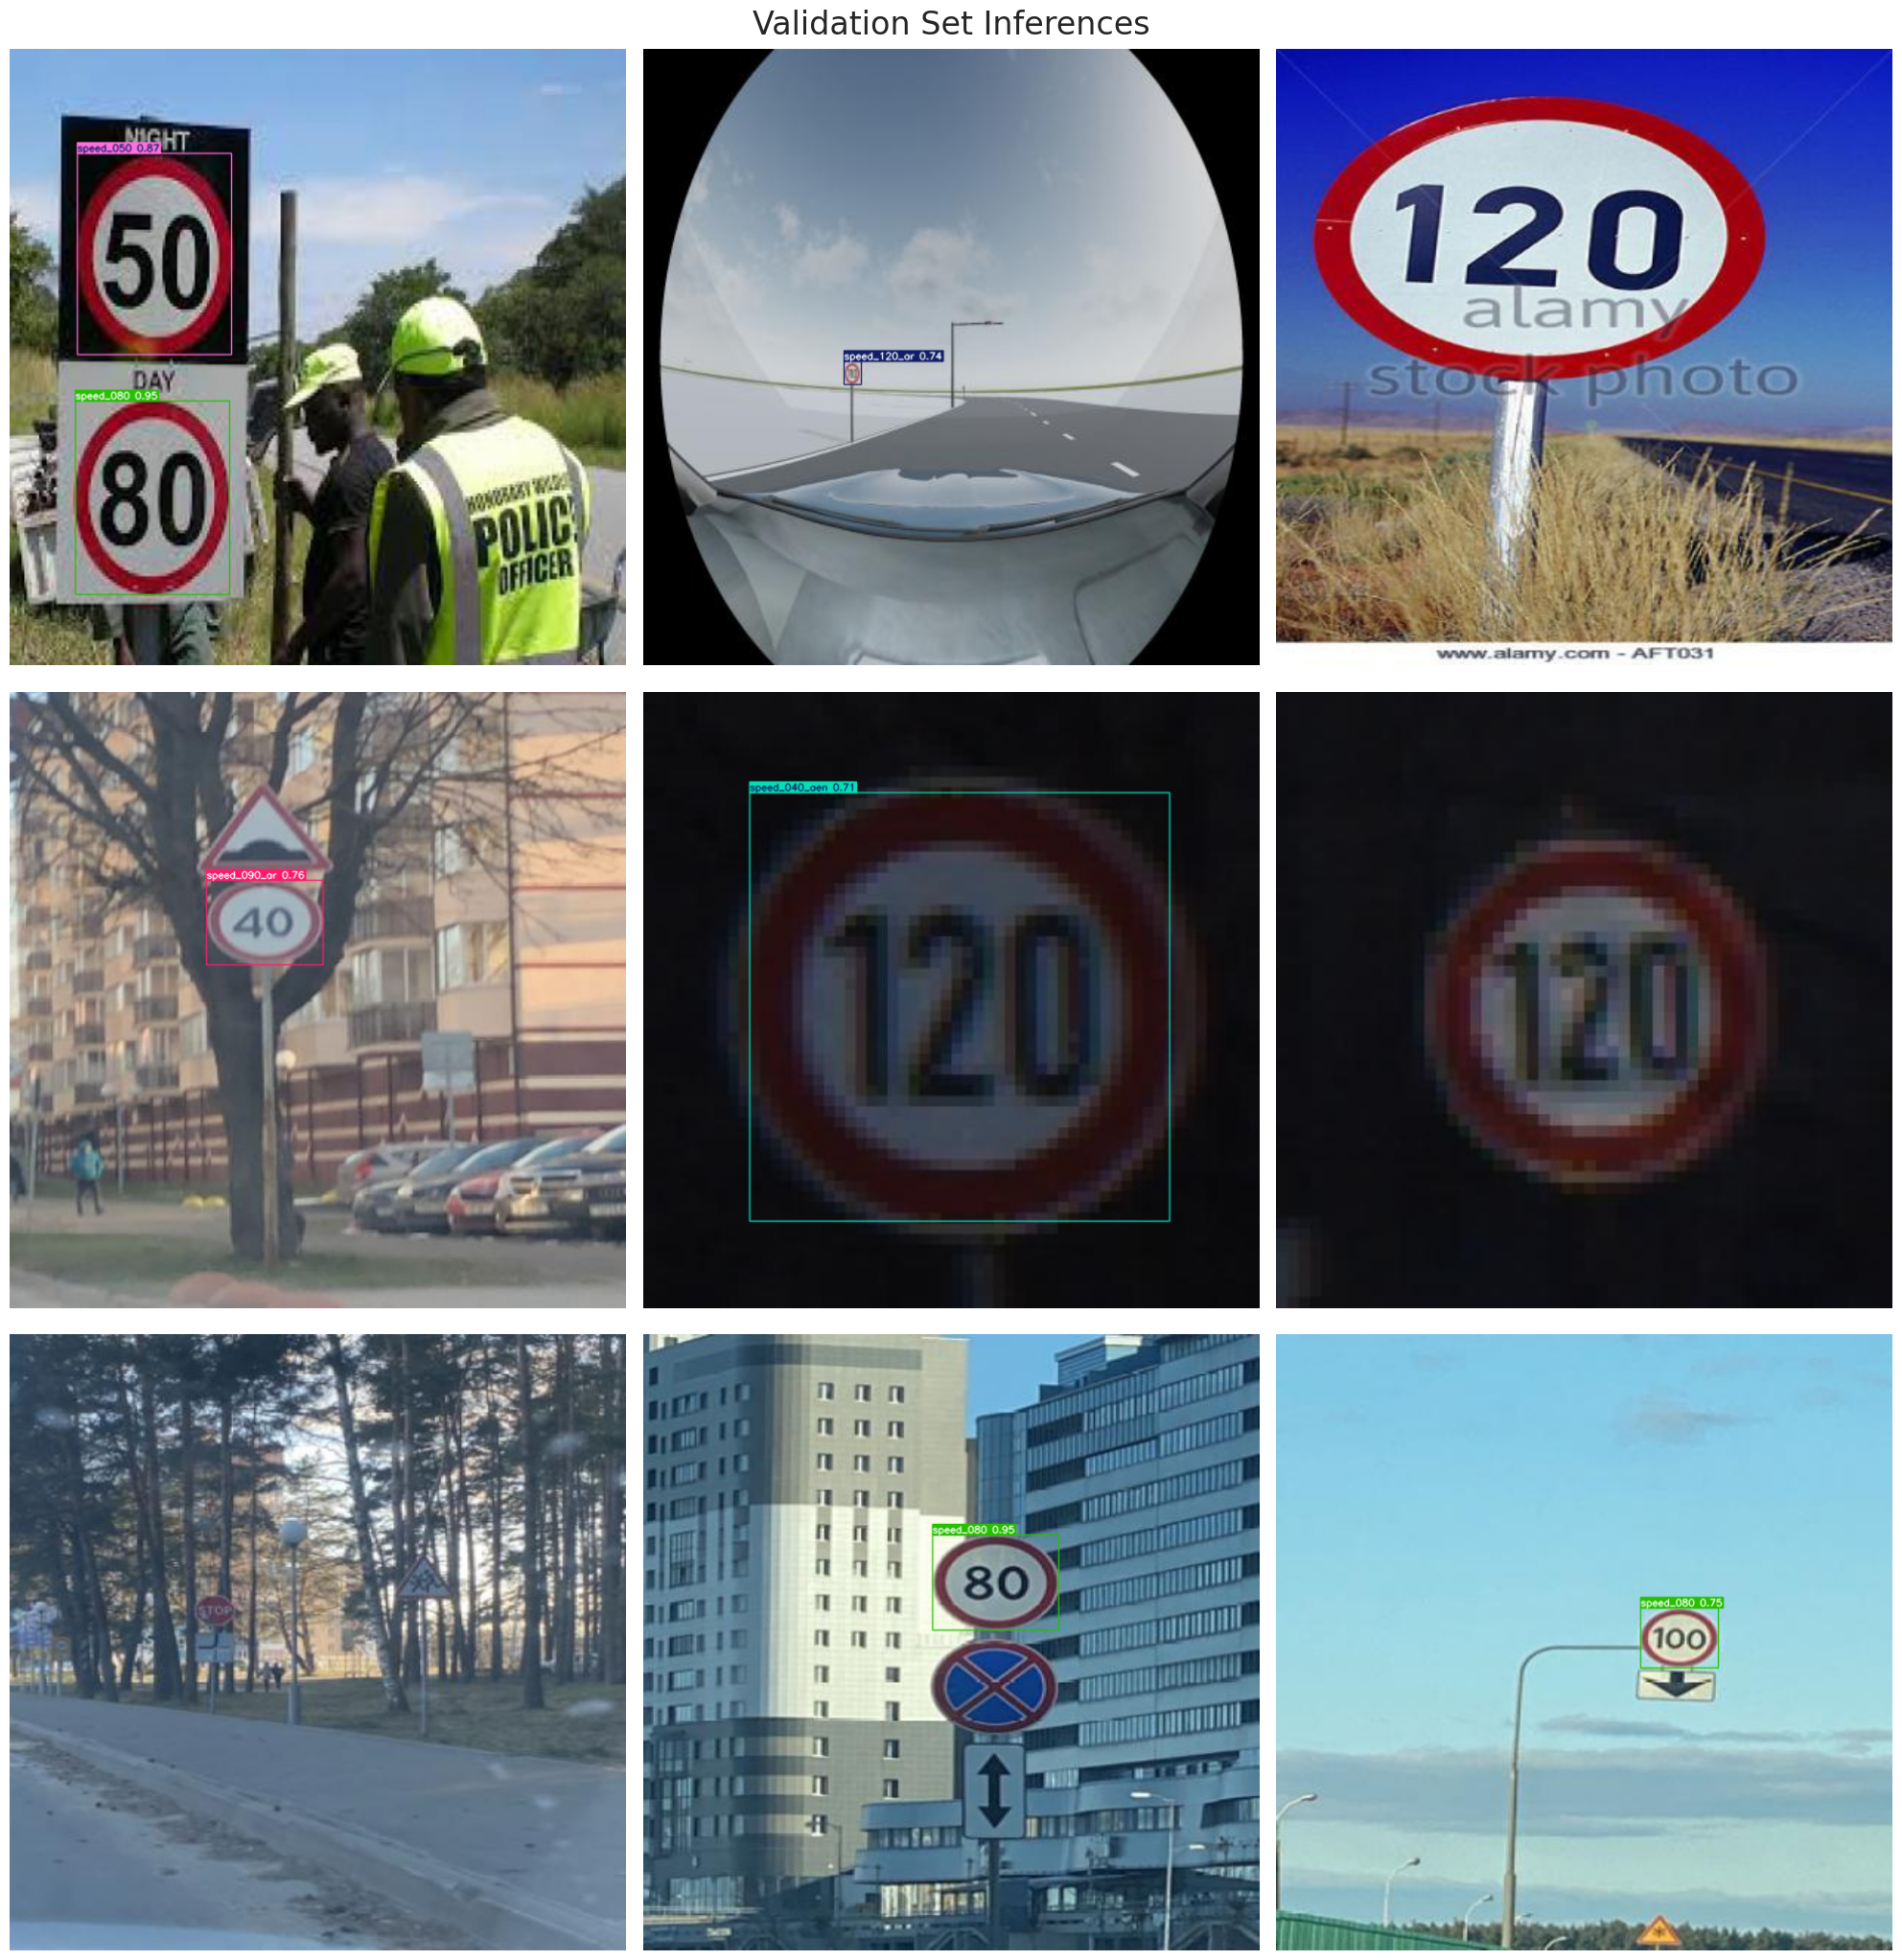

In [12]:
# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = '/kaggle/input/cardetection/car'  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle('Validation Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = Final_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Save Model 


In [12]:
Final_model.save('best_ar_big_data_v2.pt')

In [1]:
import os
import shutil

# Define paths
original_data_dir = '/kaggle/input/big-final-data-speed-signs/'
new_data_dir = '/kaggle/working/filtered_dataset/'

# Create new directory structure
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(new_data_dir, split, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(new_data_dir, split, 'images'), exist_ok=True)

In [2]:
# Original class names (from data.yaml)
original_names = [
    'speed_030', 'speed_030_aen', 'speed_040', 'speed_040_aen', 'speed_040_ar',
    'speed_050', 'speed_050_ar', 'speed_060', 'speed_060_aen', 'speed_060_ar',
    'speed_070', 'speed_070_aen', 'speed_070_ar', 'speed_080', 'speed_080_aen',
    'speed_080_ar', 'speed_090', 'speed_090_ar', 'speed_100', 'speed_100_aen',
    'speed_100_ar', 'speed_110', 'speed_110_ar', 'speed_120', 'speed_120_ar',
    'speed_130', 'speed_140_aen'
]

# Filter to keep only base classes (no suffixes)
new_names = [name for name in original_names if '_ar' not in name and '_aen' not in name]

# Create a mapping from original indices to new indices
original_indices_to_keep = [i for i, name in enumerate(original_names) if name in new_names]
class_mapping = {original_idx: new_idx for new_idx, original_idx in enumerate(original_indices_to_keep)}

In [5]:
for split in ['train', 'valid', 'test']:
    labels_dir = os.path.join(original_data_dir, split, 'labels')
    new_labels_dir = os.path.join(new_data_dir, split, 'labels')
    
    # Process each label file
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        
        original_path = os.path.join(labels_dir, label_file)
        new_path = os.path.join(new_labels_dir, label_file)
        
        with open(original_path, 'r') as f:
            lines = f.readlines()
        
        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue  # Skip empty lines
            
            class_idx = int(parts[0])
            if class_idx in class_mapping:
                new_class_idx = class_mapping[class_idx]
                new_line = f"{new_class_idx} {' '.join(parts[1:])}\n"
                new_lines.append(new_line)
        
        # Save filtered labels
        with open(new_path, 'w') as f:
            f.writelines(new_lines)
    
    # Copy images (optional if paths are read-only)
    images_dir = os.path.join(original_data_dir, split, 'images')
    new_images_dir = os.path.join(new_data_dir, split, 'images')
    for img_file in os.listdir(images_dir):
        shutil.copy(os.path.join(images_dir, img_file),  os.path.join(new_images_dir, img_file))

In [6]:
new_data_yaml = f"""
train: {os.path.join(new_data_dir, 'train', 'images')}
val: {os.path.join(new_data_dir, 'valid', 'images')}
test: {os.path.join(new_data_dir, 'test', 'images')}

nc: {len(new_names)}
names: {new_names}
"""

with open(os.path.join(new_data_dir, 'data.yaml'), 'w') as f:
    f.write(new_data_yaml)

In [1]:
import shutil, yaml, pathlib, os

# ---------- source & target ----------
src_root = pathlib.Path("/kaggle/input/big-final-data-speed-signs")
dst_root = pathlib.Path("/kaggle/working/filtered_dataset")
splits = ["train", "valid", "test"]

# ---------- class lists ----------
old_names = [
    'speed_030','speed_030_aen',
    'speed_040','speed_040_aen','speed_040_ar',
    'speed_050','speed_050_ar',
    'speed_060','speed_060_aen','speed_060_ar',
    'speed_070','speed_070_aen','speed_070_ar',
    'speed_080','speed_080_aen','speed_080_ar',
    'speed_090','speed_090_ar',
    'speed_100','speed_100_aen','speed_100_ar',
    'speed_110','speed_110_ar',
    'speed_120','speed_120_ar',
    'speed_130',
    'speed_140_aen'
]

new_names = [
    'speed_030','speed_040','speed_050','speed_060',
    'speed_070','speed_080','speed_090','speed_100',
    'speed_110','speed_120','speed_130','speed_140'
]

# ---------- id‑to‑id mapping ----------
old2new = {}
for old_id, cls in enumerate(old_names):
    base = cls.split("_ar")[0].split("_aen")[0].split("_en")[0]
    new_id = new_names.index(base)
    old2new[old_id] = new_id

print("Class‑id mapping:", old2new)

# ---------- build target folders ----------
for split in splits:
    for sub in ["images", "labels"]:
        os.makedirs(dst_root / split / sub, exist_ok=True)

# ---------- copy & convert ----------
for split in splits:
    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"

    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"

    # copy images
    for img_path in src_img_dir.rglob("*.*"):
        rel = img_path.relative_to(src_img_dir)
        dst_file = dst_img_dir / rel
        dst_file.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(img_path, dst_file)

    # rewrite & copy labels
    for lbl_path in src_lbl_dir.rglob("*.txt"):
        rel = lbl_path.relative_to(src_lbl_dir)
        dst_file = dst_lbl_dir / rel
        dst_file.parent.mkdir(parents=True, exist_ok=True)

        lines = lbl_path.read_text().strip().splitlines()
        new_lines = []
        for ln in lines:
            p = ln.split()
            p[0] = str(old2new[int(p[0])])
            new_lines.append(" ".join(p))
        dst_file.write_text("\n".join(new_lines))

print("✓ Images & labels written to", dst_root)

# ---------- write new data.yaml ----------
yaml_content = {
    "train": str(dst_root / "train" / "images"),
    "val": str(dst_root / "valid" / "images"),
    "test": str(dst_root / "test" / "images"),
    "nc": len(new_names),
    "names": new_names
}

with open(dst_root / "data.yaml", "w") as f:
    yaml.safe_dump(yaml_content, f, sort_keys=False)

print("✓ data.yaml saved")


Class‑id mapping: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4, 13: 5, 14: 5, 15: 5, 16: 6, 17: 6, 18: 7, 19: 7, 20: 7, 21: 8, 22: 8, 23: 9, 24: 9, 25: 10, 26: 11}
✓ Images & labels written to /kaggle/working/filtered_dataset
✓ data.yaml saved
